In [1]:
import pandas as pd
import numpy as np
from pycaret.regression import *
from scipy.stats import gaussian_kde
from sklearn.metrics import r2_score

from utils import *
from descriptor import *
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor

base_path = os.getcwd()
warnings.filterwarnings('ignore')
filename = "../data/features/soap_topology_total.csv"
data = pd.read_csv(filename,index_col=0)
data

,cif_file,topology,first_building_block,second_building_block_type,second_building_block,edge,f-chi-0-all,f-chi-1-all,f-chi-2-all,f-chi-3-all,f-Z-0-all,f-Z-1-all,f-Z-2-all,f-Z-3-all,f-I-0-all,f-I-1-all,f-I-2-all,f-I-3-all,f-T-0-all,f-T-1-all,f-T-2-all,f-T-3-all,f-S-0-all,f-S-1-all,f-S-2-all,f-S-3-all,mc-chi-0-all,mc-chi-1-all,mc-chi-2-all,mc-chi-3-all,mc-Z-0-all,mc-Z-1-all,mc-Z-2-all,mc-Z-3-all,mc-I-0-all,mc-I-1-all,mc-I-2-all,mc-I-3-all,mc-T-0-all,mc-T-1-all,mc-T-2-all,mc-T-3-all,mc-S-0-all,mc-S-1-all,mc-S-2-all,mc-S-3-all,D_mc-chi-0-all,D_mc-chi-1-all,D_mc-chi-2-all,D_mc-chi-3-all,D_mc-Z-0-all,D_mc-Z-1-all,D_mc-Z-2-all,D_mc-Z-3-all,D_mc-I-0-all,D_mc-I-1-all,D_mc-I-2-all,D_mc-I-3-all,D_mc-T-0-all,D_mc-T-1-all,D_mc-T-2-all,D_mc-T-3-all,D_mc-S-0-all,D_mc-S-1-all,D_mc-S-2-all,D_mc-S-3-all,f-lig-chi-0,f-lig-chi-1,f-lig-chi-2,f-lig-chi-3,f-lig-Z-0,f-lig-Z-1,f-lig-Z-2,f-lig-Z-3,f-lig-I-0,f-lig-I-1,f-lig-I-2,f-lig-I-3,f-lig-T-0,f-lig-T-1,f-lig-T-2,f-lig-T-3,f-lig-S-0,f-lig-S-1,f-lig-S-2,f-lig-S-3,lc-chi-0-all,lc-chi-1-all,lc-chi-2-all,lc-chi-3-all,lc-Z-0-all,lc-Z-1-all,lc-Z-2-all,lc-Z-3-all,lc-I-0-all,lc-I-1-all,lc-I-2-all,lc-I-3-all,lc-T-0-all,lc-T-1-all,lc-T-2-all,lc-T-3-all,lc-S-0-all,lc-S-1-all,lc-S-2-all,lc-S-3-all,lc-alpha-0-all,lc-alpha-1-all,lc-alpha-2-all,lc-alpha-3-all,D_lc-chi-0-all,D_lc-chi-1-all,D_lc-chi-2-all,D_lc-chi-3-all,D_lc-Z-0-all,D_lc-Z-1-all,D_lc-Z-2-all,D_lc-Z-3-all,D_lc-I-0-all,D_lc-I-1-all,D_lc-I-2-all,D_lc-I-3-all,D_lc-T-0-all,D_lc-T-1-all,D_lc-T-2-all,D_lc-T-3-all,D_lc-S-0-all,D_lc-S-1-all,D_lc-S-2-all,D_lc-S-3-all,D_lc-alpha-0-all,D_lc-alpha-1-all,D_lc-alpha-2-all,D_lc-alpha-3-all,func-chi-0-all,func-chi-1-all,func-chi-2-all,func-chi-3-all,func-Z-0-all,func-Z-1-all,func-Z-2-all,func-Z-3-all,func-I-0-all,func-I-1-all,func-I-2-all,func-I-3-all,func-T-0-all,func-T-1-all,func-T-2-all,func-T-3-all,func-S-0-all,func-S-1-all,func-S-2-all,func-S-3-all,func-alpha-0-all,func-alpha-1-all,func-alpha-2-all,func-alpha-3-all,D_func-chi-0-all,D_func-chi-1-all,D_func-chi-2-all,D_func-chi-3-all,D_func-Z-0-all,D_func-Z-1-all,D_func-Z-2-all,D_func-Z-3-all,D_func-I-0-all,D_func-I-1-all,D_func-I-2-all,D_func-I-3-all,D_func-T-0-all,D_func-T-1-all,D_func-T-2-all,D_func-T-3-all,D_func-S-0-all,D_func-S-1-all,D_func-S-2-all,D_func-S-3-all,D_func-alpha-0-all,D_func-alpha-1-all,D_func-alpha-2-all,D_func-alpha-3-all,Di,Df,Dif,rho,VSA,GSA,VPOV,GPOV,POAV_vol_frac,PONAV_vol_frac,GPOAV,GPONAV,POAV,PONAV,KVRH,GVRH,soap0,soap1,soap2,soap3,soap4,soap5,soap6,soap7,soap8,soap9,soap10,soap11,soap12,soap13,soap14,soap15,soap16,soap17,soap18,soap19,soap20,soap21,soap22,soap23,soap24,soap25,soap26,soap27,soap28,soap29,soap30,soap31,soap32,soap33,soap34,soap35,soap36,soap37,soap38,soap39,soap40,soap41,soap42,soap43,soap44,soap45,soap46,soap47,soap48,soap49,soap50,soap51,...,soap7310,soap7311,soap7312,soap7313,soap7314,soap7315,soap7316,soap7317,soap7318,soap7319,soap7320,soap7321,soap7322,soap7323,soap7324,soap7325,soap7326,soap7327,soap7328,soap7329,soap7330,soap7331,soap7332,soap7333,soap7334,soap7335,soap7336,soap7337,soap7338,soap7339,soap7340,soap7341,soap7342,soap7343,soap7344,soap7345,soap7346,soap7347,soap7348,soap7349,soap7350,soap7351,soap7352,soap7353,soap7354,soap7355,soap7356,soap7357,soap7358,soap7359,soap7360,soap7361,soap7362,soap7363,soap7364,soap7365,soap7366,soap7367,soap7368,soap7369,soap7370,soap7371,soap7372,soap7373,soap7374,soap7375,soap7376,soap7377,soap7378,soap7379,soap7380,soap7381,soap7382,soap7383,soap7384,soap7385,soap7386,soap7387,soap7388,soap7389,soap7390,soap7391,soap7392,soap7393,soap7394,soap7395,soap7396,soap7397,soap7398,soap7399,soap7400,soap7401,soap7402,soap7403,soap7404,soap7405,soap7406,soap7407,soap7408,soap7409,soap7410,soap7411,soap7412,soap7413,soap7414,soap7415,soap7416,soap7417,soap7418,soap7419,soap7420,soap7421,soap7422,soap7423,soap7424,soap7425,soap7426,soap7427,soap7428,soap7429,soap7430,soap7431,soap7432,soap7433,soap7434,soap7435,soap7436,soap7437,soap7438,soap7439,soap7440,soap7441,soap7442,

In [2]:
tobacco = pd.read_csv("../data/features/total_tobacco.csv")
tobacco_cif = tobacco["cif_file"]

In [3]:
tobacco = data[data["cif_file"].isin(tobacco_cif)]

In [4]:
soap_columns = list(data.columns)[198:]

columns = geometric + RAC + soap_columns + property_
new_columns = geometric + RAC + soap_columns
descriptors = tobacco[new_columns]
drop_col = remove_constant_value_features(descriptors)
new_df_columns = [e for e in descriptors.columns if e not in drop_col]
property_ = ["KVRH"]


In [8]:
X = tobacco[new_df_columns]
y = tobacco[property_]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 2706, random_state=42)

In [ ]:
import optuna
from sklearn import datasets

def objective(trial):
    
        
    learning_rate = trial.suggest_discrete_uniform("learning_rate", 0.001, 0.1, 0.005)
  
    depth = trial.suggest_int('depth', 5, 10)
                
    l2_leaf_reg = trial.suggest_discrete_uniform('l2_leaf_reg', 2.0, 30.0, 0.5)
        
    min_child_samples = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
        
    grow_policy = trial.suggest_categorical("grow_policy",["SymmetricTree", "Depthwise", "Lossguide"])
    
    accuracy = []
    model = CatBoostRegressor(random_state=42,
                              learning_rate=learning_rate,
                              depth = depth,
                              l2_leaf_reg = l2_leaf_reg,
                              min_child_samples = min_child_samples,
                              grow_policy = grow_policy,
                              silent = True) 

    model.fit(X_train, y_train) 

    y_pred = model.predict(X_test)
        
    score = r2_score(y_test,y_pred)
    

    return score
    
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials = 1000)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print("best r2 is :",study.best_trial.values)

[I 2023-06-15 18:32:22,270] A new study created in memory with name: no-name-9f48042d-d515-43c7-9985-7139fa1a8066
[I 2023-06-15 18:33:58,266] Trial 0 finished with value: 0.9309151731962932 and parameters: {'learning_rate': 0.096, 'depth': 6, 'l2_leaf_reg': 2.0, 'min_child_samples': 4, 'grow_policy': 'Lossguide'}. Best is trial 0 with value: 0.9309151731962932.
[I 2023-06-15 18:36:02,932] Trial 1 finished with value: 0.9337309917508965 and parameters: {'learning_rate': 0.026000000000000002, 'depth': 9, 'l2_leaf_reg': 20.5, 'min_child_samples': 4, 'grow_policy': 'Lossguide'}. Best is trial 1 with value: 0.9337309917508965.
[I 2023-06-15 18:47:15,147] Trial 2 finished with value: 0.9044374896151279 and parameters: {'learning_rate': 0.021, 'depth': 10, 'l2_leaf_reg': 24.5, 'min_child_samples': 1, 'grow_policy': 'SymmetricTree'}. Best is trial 1 with value: 0.9337309917508965.
[I 2023-06-15 18:49:44,757] Trial 3 finished with value: 0.9508628982005826 and parameters: {'learning_rate': 0.08

[I 2023-06-15 19:28:46,356] Trial 30 finished with value: 0.9391357861824499 and parameters: {'learning_rate': 0.091, 'depth': 6, 'l2_leaf_reg': 27.5, 'min_child_samples': 8, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 0.9508628982005826.
[I 2023-06-15 19:29:45,042] Trial 31 finished with value: 0.944100502094363 and parameters: {'learning_rate': 0.091, 'depth': 6, 'l2_leaf_reg': 21.0, 'min_child_samples': 8, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 0.9508628982005826.
[I 2023-06-15 19:30:58,074] Trial 32 finished with value: 0.9403827852050882 and parameters: {'learning_rate': 0.091, 'depth': 7, 'l2_leaf_reg': 20.0, 'min_child_samples': 8, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 0.9508628982005826.
[I 2023-06-15 19:31:40,125] Trial 33 finished with value: 0.9382907814197191 and parameters: {'learning_rate': 0.081, 'depth': 5, 'l2_leaf_reg': 21.5, 'min_child_samples': 8, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 0.95086289820

[I 2023-06-15 20:12:01,197] Trial 61 finished with value: 0.9376265712377778 and parameters: {'learning_rate': 0.08600000000000001, 'depth': 6, 'l2_leaf_reg': 17.5, 'min_child_samples': 8, 'grow_policy': 'Depthwise'}. Best is trial 3 with value: 0.9508628982005826.
[I 2023-06-15 20:13:05,903] Trial 62 finished with value: 0.9421702727218367 and parameters: {'learning_rate': 0.091, 'depth': 6, 'l2_leaf_reg': 16.5, 'min_child_samples': 8, 'grow_policy': 'Depthwise'}. Best is trial 3 with value: 0.9508628982005826.
[I 2023-06-15 20:14:06,746] Trial 63 finished with value: 0.9431743424405767 and parameters: {'learning_rate': 0.081, 'depth': 6, 'l2_leaf_reg': 14.5, 'min_child_samples': 8, 'grow_policy': 'SymmetricTree'}. Best is trial 3 with value: 0.9508628982005826.
[I 2023-06-15 20:15:07,193] Trial 64 finished with value: 0.9378981263841818 and parameters: {'learning_rate': 0.096, 'depth': 6, 'l2_leaf_reg': 20.5, 'min_child_samples': 8, 'grow_policy': 'Lossguide'}. Best is trial 3 with v

[I 2023-06-15 20:47:41,407] Trial 92 finished with value: 0.9363568143696753 and parameters: {'learning_rate': 0.076, 'depth': 6, 'l2_leaf_reg': 12.0, 'min_child_samples': 32, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 0.9508628982005826.
[I 2023-06-15 20:48:59,334] Trial 93 finished with value: 0.9392833145655213 and parameters: {'learning_rate': 0.07100000000000001, 'depth': 6, 'l2_leaf_reg': 13.5, 'min_child_samples': 4, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 0.9508628982005826.
[I 2023-06-15 20:49:51,916] Trial 94 finished with value: 0.9405368153577266 and parameters: {'learning_rate': 0.081, 'depth': 6, 'l2_leaf_reg': 9.0, 'min_child_samples': 16, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 0.9508628982005826.
[I 2023-06-15 20:50:51,979] Trial 95 finished with value: 0.939105931945815 and parameters: {'learning_rate': 0.081, 'depth': 7, 'l2_leaf_reg': 16.5, 'min_child_samples': 16, 'grow_policy': 'Lossguide'}. Best is trial 3 with valu

[I 2023-06-15 21:17:54,439] Trial 123 finished with value: 0.941172353530024 and parameters: {'learning_rate': 0.07100000000000001, 'depth': 6, 'l2_leaf_reg': 30.0, 'min_child_samples': 16, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 0.9508628982005826.
[I 2023-06-15 21:18:38,173] Trial 124 finished with value: 0.9439066200387458 and parameters: {'learning_rate': 0.066, 'depth': 6, 'l2_leaf_reg': 23.5, 'min_child_samples': 16, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 0.9508628982005826.
[I 2023-06-15 21:19:13,995] Trial 125 finished with value: 0.9417148109346128 and parameters: {'learning_rate': 0.081, 'depth': 6, 'l2_leaf_reg': 29.5, 'min_child_samples': 32, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 0.9508628982005826.
[I 2023-06-15 21:19:58,816] Trial 126 finished with value: 0.941226924138075 and parameters: {'learning_rate': 0.091, 'depth': 6, 'l2_leaf_reg': 28.5, 'min_child_samples': 16, 'grow_policy': 'Lossguide'}. Best is trial 3 with

[I 2023-06-15 21:50:34,370] Trial 154 finished with value: 0.9425234537263836 and parameters: {'learning_rate': 0.081, 'depth': 6, 'l2_leaf_reg': 26.0, 'min_child_samples': 32, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 0.9508628982005826.
[I 2023-06-15 21:51:11,172] Trial 155 finished with value: 0.9315098700886226 and parameters: {'learning_rate': 0.091, 'depth': 6, 'l2_leaf_reg': 24.5, 'min_child_samples': 32, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 0.9508628982005826.
[I 2023-06-15 21:51:55,289] Trial 156 finished with value: 0.9345950877985869 and parameters: {'learning_rate': 0.076, 'depth': 6, 'l2_leaf_reg': 7.0, 'min_child_samples': 32, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 0.9508628982005826.
[I 2023-06-15 21:52:39,396] Trial 157 finished with value: 0.9394716664153011 and parameters: {'learning_rate': 0.07100000000000001, 'depth': 6, 'l2_leaf_reg': 27.0, 'min_child_samples': 16, 'grow_policy': 'Lossguide'}. Best is trial 3 wit

[I 2023-06-15 22:18:56,264] Trial 185 finished with value: 0.9398796496278029 and parameters: {'learning_rate': 0.081, 'depth': 8, 'l2_leaf_reg': 27.5, 'min_child_samples': 32, 'grow_policy': 'Depthwise'}. Best is trial 3 with value: 0.9508628982005826.
[I 2023-06-15 22:19:55,750] Trial 186 finished with value: 0.9441282019846888 and parameters: {'learning_rate': 0.08600000000000001, 'depth': 8, 'l2_leaf_reg': 28.0, 'min_child_samples': 32, 'grow_policy': 'Depthwise'}. Best is trial 3 with value: 0.9508628982005826.
[I 2023-06-15 22:20:53,212] Trial 187 finished with value: 0.9440304717588633 and parameters: {'learning_rate': 0.081, 'depth': 8, 'l2_leaf_reg': 30.0, 'min_child_samples': 32, 'grow_policy': 'Depthwise'}. Best is trial 3 with value: 0.9508628982005826.
[I 2023-06-15 22:21:50,958] Trial 188 finished with value: 0.9423823780753513 and parameters: {'learning_rate': 0.091, 'depth': 8, 'l2_leaf_reg': 28.5, 'min_child_samples': 32, 'grow_policy': 'Depthwise'}. Best is trial 3 wi

[I 2023-06-15 23:20:08,490] Trial 216 finished with value: 0.9295088739718871 and parameters: {'learning_rate': 0.096, 'depth': 7, 'l2_leaf_reg': 25.0, 'min_child_samples': 1, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 0.9508628982005826.
[I 2023-06-15 23:22:41,570] Trial 217 finished with value: 0.9264547987278493 and parameters: {'learning_rate': 0.096, 'depth': 7, 'l2_leaf_reg': 27.0, 'min_child_samples': 1, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 0.9508628982005826.
[I 2023-06-15 23:25:18,246] Trial 218 finished with value: 0.9417088038924963 and parameters: {'learning_rate': 0.091, 'depth': 7, 'l2_leaf_reg': 2.0, 'min_child_samples': 1, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 0.9508628982005826.
[I 2023-06-15 23:27:06,795] Trial 219 finished with value: 0.9408807984586772 and parameters: {'learning_rate': 0.096, 'depth': 7, 'l2_leaf_reg': 26.0, 'min_child_samples': 1, 'grow_policy': 'SymmetricTree'}. Best is trial 3 with value: 0.950

[I 2023-06-15 23:54:04,358] Trial 247 finished with value: 0.9477951124496791 and parameters: {'learning_rate': 0.091, 'depth': 6, 'l2_leaf_reg': 28.5, 'min_child_samples': 8, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 0.9508628982005826.
[I 2023-06-15 23:54:57,939] Trial 248 finished with value: 0.9477951124496791 and parameters: {'learning_rate': 0.091, 'depth': 6, 'l2_leaf_reg': 28.5, 'min_child_samples': 8, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 0.9508628982005826.
[I 2023-06-15 23:56:45,048] Trial 250 finished with value: 0.9477951124496791 and parameters: {'learning_rate': 0.091, 'depth': 6, 'l2_leaf_reg': 28.5, 'min_child_samples': 8, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 0.9508628982005826.
[I 2023-06-15 23:57:38,603] Trial 251 finished with value: 0.9477951124496791 and parameters: {'learning_rate': 0.091, 'depth': 6, 'l2_leaf_reg': 28.5, 'min_child_samples': 8, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 0.950862

In [20]:
study.best_trial.params

{'learning_rate': 0.046,
 'depth': 10,
 'l2_leaf_reg': 5.5,
 'min_child_samples': 32,
 'grow_policy': 'Lossguide'}

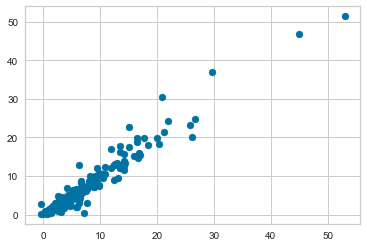

In [13]:
import matplotlib.pyplot as plt
plt.scatter(y_pred,y_test)

In [14]:
r2_score(y_test,y_pred)

0.9428582454914893

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 2706, random_state=42)

learning_rate = 0.051000000000000004 
depth = 6
l2_leaf_reg = 17.0
min_child_samples= 16
grow_policy = "Depthwise"

model = CatBoostRegressor(random_state=42,
                          learning_rate=learning_rate,
                          depth = depth,
                          l2_leaf_reg = l2_leaf_reg,
                          min_child_samples = min_child_samples,
                          grow_policy = grow_policy,
                          silent = True)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(r2_score(y_test,y_pred))

0.9428582454914893
